In [1]:
!pip install --upgrade --quiet google-cloud-aiplatform
!pip install evidently fairlearn shap matplotlib seaborn
!pip install --upgrade scikit-learn pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 91.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 573.2/573.2 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: plotlym━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  4/17 [regex]
    Found existing installation: plotly 6.1.2━━━━━━━━━━━━━━━━━  4/17 [regex]
    Uninstalling plotly-6.1.2:━━━━━━━━━━━━━━━━━━━━━━━━━━━━  5/17 [plotly]
      Successfully uninstalled plotly-6.1.2━━━━━━━━━━━━━━━━━━━  5/17 [plotly]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17/17 [evidently]17 [evidently]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 91.5 MB

In [2]:
PROJECT_ID = "true-sprite-459511-f5"  # Update with your project ID
LOCATION = "us-central1"
BUCKET_URI = f"gs://mlops-course-true-sprite-459511-f5-unique-week9-stuff"

In [3]:
from google.cloud import aiplatform
aiplatform.init(project=PROJECT_ID, location=LOCATION, staging_bucket=BUCKET_URI)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.datasets import load_iris
import warnings
warnings.filterwarnings('ignore')

# Governance tools
import shap
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import selection_rate, demographic_parity_difference
from fairlearn.postprocessing import ThresholdOptimizer
from evidently import Dataset
from evidently import DataDefinition
from evidently import Report
from evidently.presets import DataDriftPreset, DataSummaryPreset

# Set random seed for reproducibility
np.random.seed(42)

In [5]:
iris = load_iris()
data = pd.DataFrame(iris.data, columns=iris.feature_names)
data['species'] = iris.target
data['species'] = data['species'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

# ASSIGNMENT REQUIREMENT 1: Add location attribute with random 0/1 values
print("Adding 'location' attribute to IRIS dataset...")
data['location'] = np.random.choice([0, 1], size=len(data), p=[0.5, 0.5])

print(f"Dataset shape: {data.shape}")
print("\nFirst 10 rows with location attribute:")
print(data.head(10))

print(f"\nLocation distribution:")
print(data['location'].value_counts())
print(f"Location 0: {(data['location'] == 0).sum()} samples")
print(f"Location 1: {(data['location'] == 1).sum()} samples")

Adding 'location' attribute to IRIS dataset...
Dataset shape: (150, 6)

First 10 rows with location attribute:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   
5                5.4               3.9                1.7               0.4   
6                4.6               3.4                1.4               0.3   
7                5.0               3.4                1.5               0.2   
8                4.4               2.9                1.4               0.2   
9                4.9               3.1                1.5               0.1   

  species  location

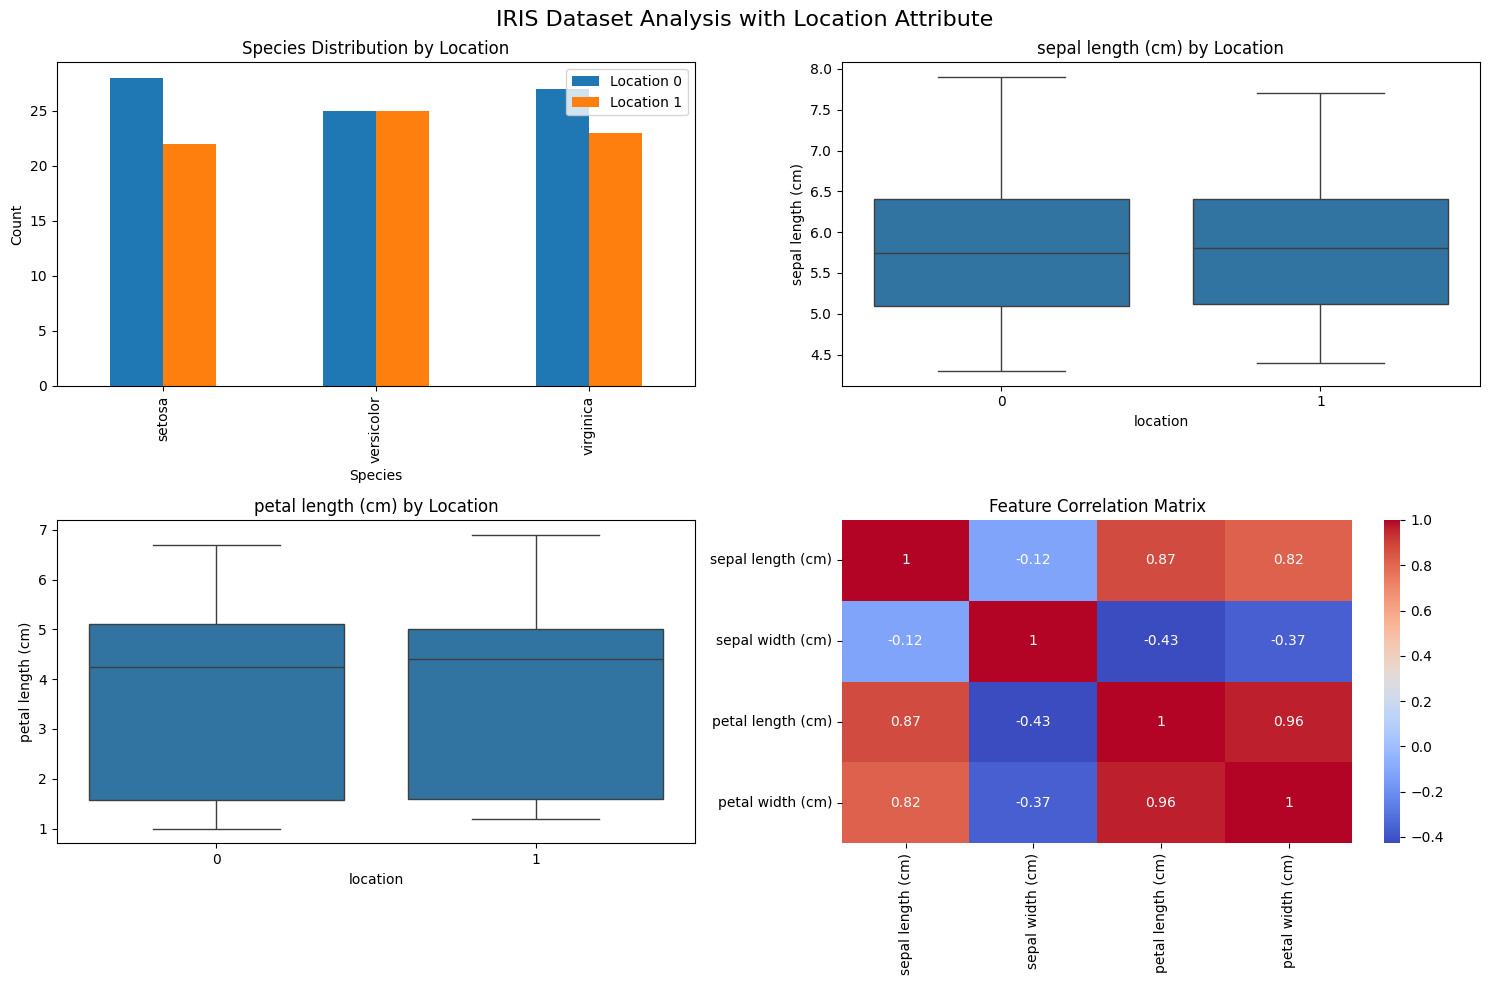

In [7]:
# Visualize data distribution by location and species
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('IRIS Dataset Analysis with Location Attribute', fontsize=16)

# Species distribution by location
species_location = pd.crosstab(data['species'], data['location'])
species_location.plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Species Distribution by Location')
axes[0,0].set_xlabel('Species')
axes[0,0].set_ylabel('Count')
axes[0,0].legend(['Location 0', 'Location 1'])

# Feature distributions by location
for i, feature in enumerate(['sepal length (cm)', 'petal length (cm)']):
    ax = axes[0,1] if i==0 else axes[1,0]
    sns.boxplot(data=data, x='location', y=feature, ax=ax)
    ax.set_title(f'{feature} by Location')

# Correlation matrix
correlation_matrix = data[iris.feature_names].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=axes[1,1])
axes[1,1].set_title('Feature Correlation Matrix')

plt.tight_layout()
plt.show()

In [8]:
# Prepare features and target
feature_columns = iris.feature_names
X = data[feature_columns]
y = data['species']
sensitive_feature = data['location']  # Location as sensitive attribute

# Split the data
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X, y, sensitive_feature, test_size=0.4, stratify=y, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training location distribution: {sensitive_train.value_counts().to_dict()}")
print(f"Test location distribution: {sensitive_test.value_counts().to_dict()}")

# Train Decision Tree model
params = {
    "max_depth": 4,
    "random_state": 42,
    "min_samples_split": 5,
    "min_samples_leaf": 2
}

model = DecisionTreeClassifier(**params)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Calculate accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f'\nModel Accuracy: {accuracy:.3f}')

# Detailed classification report
print("\nClassification Report:")
print(metrics.classification_report(y_test, y_pred))

Training set size: 90
Test set size: 60
Training location distribution: {1: 46, 0: 44}
Test location distribution: {0: 36, 1: 24}

Model Accuracy: 0.983

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        20
  versicolor       1.00      0.95      0.97        20
   virginica       0.95      1.00      0.98        20

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



In [9]:
# Calculate fairness metrics
def analyze_fairness(y_true, y_pred, sensitive_features, model_name="Model"):
    """Comprehensive fairness analysis"""
    
    print(f"\n{model_name} Fairness Analysis:")
    print("-" * 40)
    
    # Create MetricFrame for comprehensive analysis
    mf = MetricFrame(
        metrics={
            'accuracy': metrics.accuracy_score,
            'precision': lambda y_true, y_pred: metrics.precision_score(y_true, y_pred, average='weighted'),
            'recall': lambda y_true, y_pred: metrics.recall_score(y_true, y_pred, average='weighted'),
            'f1_score': lambda y_true, y_pred: metrics.f1_score(y_true, y_pred, average='weighted')
        },
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sensitive_features
    )
    
    print("Overall Metrics:")
    print(mf.overall)
    
    print("\nMetrics by Sensitive Group (Location):")
    print(mf.by_group)
    
    print("\nFairness Differences:")
    print(mf.difference())
    
    return mf

# Perform fairness analysis
fairness_metrics = analyze_fairness(y_test, y_pred, sensitive_test, "Decision Tree")

classes = ['setosa', 'versicolor', 'virginica']
for class_name in classes:
    print(f"\n--- {class_name.upper()} CLASS ANALYSIS ---")
    
    # Binary classification for this class
    y_binary = (y_test == class_name).astype(int)
    y_pred_binary = (y_pred == class_name).astype(int)
    
    # Calculate metrics by location
    location_0_mask = sensitive_test == 0
    location_1_mask = sensitive_test == 1
    
    acc_loc_0 = metrics.accuracy_score(y_binary[location_0_mask], y_pred_binary[location_0_mask])
    acc_loc_1 = metrics.accuracy_score(y_binary[location_1_mask], y_pred_binary[location_1_mask])
    
    prec_loc_0 = metrics.precision_score(y_binary[location_0_mask], y_pred_binary[location_0_mask], zero_division=0)
    prec_loc_1 = metrics.precision_score(y_binary[location_1_mask], y_pred_binary[location_1_mask], zero_division=0)
    
    print(f"Location 0 - Accuracy: {acc_loc_0:.3f}, Precision: {prec_loc_0:.3f}")
    print(f"Location 1 - Accuracy: {acc_loc_1:.3f}, Precision: {prec_loc_1:.3f}")
    print(f"Accuracy Difference: {abs(acc_loc_0 - acc_loc_1):.3f}")
    print(f"Precision Difference: {abs(prec_loc_0 - prec_loc_1):.3f}")


Decision Tree Fairness Analysis:
----------------------------------------
Overall Metrics:
accuracy     0.983333
precision    0.984127
recall       0.983333
f1_score     0.983323
dtype: float64

Metrics by Sensitive Group (Location):
          accuracy  precision    recall  f1_score
location                                         
0         0.972222   0.974206  0.972222  0.972133
1         1.000000   1.000000  1.000000  1.000000

Fairness Differences:
accuracy     0.027778
precision    0.025794
recall       0.027778
f1_score     0.027867
dtype: float64

--- SETOSA CLASS ANALYSIS ---
Location 0 - Accuracy: 1.000, Precision: 1.000
Location 1 - Accuracy: 1.000, Precision: 1.000
Accuracy Difference: 0.000
Precision Difference: 0.000

--- VERSICOLOR CLASS ANALYSIS ---
Location 0 - Accuracy: 0.972, Precision: 1.000
Location 1 - Accuracy: 1.000, Precision: 1.000
Accuracy Difference: 0.028
Precision Difference: 0.000

--- VIRGINICA CLASS ANALYSIS ---
Location 0 - Accuracy: 0.972, Precision: 

In [10]:
# Apply ThresholdOptimizer for bias mitigation
print("Applying ThresholdOptimizer for demographic parity...")

# For multi-class, we'll focus on the most imbalanced class predictions
# Convert to binary problem for demonstration
y_train_binary = (y_train == 'virginica').astype(int)
y_test_binary = (y_test == 'virginica').astype(int)

# Train a binary classifier for virginica
binary_model = DecisionTreeClassifier(**params)
binary_model.fit(X_train, y_train_binary)

# Apply ThresholdOptimizer
threshold_optimizer = ThresholdOptimizer(
    estimator=binary_model,
    constraints="demographic_parity",
    objective="accuracy_score"
)

threshold_optimizer.fit(X_train, y_train_binary, sensitive_features=sensitive_train)

# Get fair predictions
y_pred_fair = threshold_optimizer.predict(X_test, sensitive_features=sensitive_test)

print("Before bias mitigation:")
original_fairness = analyze_fairness(y_test_binary, binary_model.predict(X_test), sensitive_test, "Original Model")

print("\nAfter bias mitigation:")
fair_fairness = analyze_fairness(y_test_binary, y_pred_fair, sensitive_test, "Fair Model")

Applying ThresholdOptimizer for demographic parity...
Before bias mitigation:

Original Model Fairness Analysis:
----------------------------------------
Overall Metrics:
accuracy     0.916667
precision    0.918377
recall       0.916667
f1_score     0.914794
dtype: float64

Metrics by Sensitive Group (Location):
          accuracy  precision    recall  f1_score
location                                         
0         0.888889   0.890505  0.888889  0.886574
1         0.958333   0.960648  0.958333  0.957326

Fairness Differences:
accuracy     0.069444
precision    0.070143
recall       0.069444
f1_score     0.070752
dtype: float64

After bias mitigation:

Fair Model Fairness Analysis:
----------------------------------------
Overall Metrics:
accuracy     0.900000
precision    0.899471
recall       0.900000
f1_score     0.898588
dtype: float64

Metrics by Sensitive Group (Location):
          accuracy  precision    recall  f1_score
location                                         
0   

In [18]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Debug: Check the structure of shap_values
print(f"SHAP values type: {type(shap_values)}")
if isinstance(shap_values, list):
    print(f"SHAP values is a list with {len(shap_values)} elements")
    for i, sv in enumerate(shap_values):
        print(f"  Element {i} shape: {sv.shape}")
else:
    print(f"SHAP values shape: {shap_values.shape}")

print(f"Model classes: {model.classes_}")
print(f"Expected values: {explainer.expected_value}")

# Get virginica class index
virginica_class_idx = list(model.classes_).index('virginica')
print(f"Virginica class index: {virginica_class_idx}")

print("\nSHAP Analysis Results for Virginica Class:")
print("-" * 50)

# SHAP values for virginica class
if isinstance(shap_values, list):
    virginica_shap_values = shap_values[virginica_class_idx]
else:
    # If shap_values is not a list, it might be a 3D array
    virginica_shap_values = shap_values[:, :, virginica_class_idx] if shap_values.ndim == 3 else shap_values

print(f"SHAP values shape for virginica: {virginica_shap_values.shape}")
print(f"Base value (expected value) for virginica: {explainer.expected_value[virginica_class_idx]:.4f}")

# Feature importance analysis
feature_importance = np.abs(virginica_shap_values).mean(axis=0)
feature_names = X_test.columns.tolist()

# Ensure lengths match
print(f"Feature names length: {len(feature_names)}")
print(f"Feature importance length: {len(feature_importance)}")

if len(feature_names) != len(feature_importance):
    print("ERROR: Mismatch in lengths!")
    print(f"virginica_shap_values shape: {virginica_shap_values.shape}")
    # Try to fix by ensuring we have the right dimensions
    if virginica_shap_values.shape[1] == len(feature_names):
        feature_importance = np.abs(virginica_shap_values).mean(axis=0)
    else:
        print("Cannot resolve dimension mismatch")
        feature_importance = np.zeros(len(feature_names))

print(f"\nFeature Importance for Virginica Class (Mean |SHAP value|):")
for i, (feature, importance) in enumerate(zip(feature_names, feature_importance)):
    print(f"{i+1}. {feature}: {importance:.4f}")

# Detailed analysis for top contributing samples
print(f"\nTop 5 samples with highest absolute SHAP values for Virginica:")
sample_contributions = np.abs(virginica_shap_values).sum(axis=1)
top_samples_idx = np.argsort(sample_contributions)[-5:]

for i, idx in enumerate(reversed(top_samples_idx)):
    sample_shap = virginica_shap_values[idx]
    sample_features = X_test.iloc[idx]
    actual_class = y_test.iloc[idx]
    predicted_class = y_pred[idx]
    location = sensitive_test.iloc[idx]
    
    print(f"\nSample {i+1} (Index {idx}):")
    print(f"  Actual class: {actual_class}")
    print(f"  Predicted class: {predicted_class}")
    print(f"  Location: {location}")
    print(f"  Total SHAP contribution: {sample_shap.sum():.4f}")
    print(f"  Feature contributions:")
    
    for feature, shap_val, feature_val in zip(feature_names, sample_shap, sample_features):
        print(f"    {feature}: SHAP={shap_val:+.4f}, Value={feature_val:.2f}")

SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (60, 4, 3)
Model classes: ['setosa' 'versicolor' 'virginica']
Expected values: [0.33333333 0.33333333 0.33333333]
Virginica class index: 2

SHAP Analysis Results for Virginica Class:
--------------------------------------------------
SHAP values shape for virginica: (60, 4)
Base value (expected value) for virginica: 0.3333
Feature names length: 4
Feature importance length: 4

Feature Importance for Virginica Class (Mean |SHAP value|):
1. sepal length (cm): 0.0000
2. sepal width (cm): 0.0000
3. petal length (cm): 0.3262
4. petal width (cm): 0.1147

Top 5 samples with highest absolute SHAP values for Virginica:

Sample 1 (Index 32):
  Actual class: virginica
  Predicted class: virginica
  Location: 1
  Total SHAP contribution: 0.3333
  Feature contributions:
    sepal length (cm): SHAP=+0.0000, Value=6.10
    sepal width (cm): SHAP=+0.0000, Value=2.60
    petal length (cm): SHAP=+0.5420, Value=5.60
    petal width (cm): SHAP=-0

Virginica SHAP values shape: (60, 4)
Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Feature importance shape: (4,)


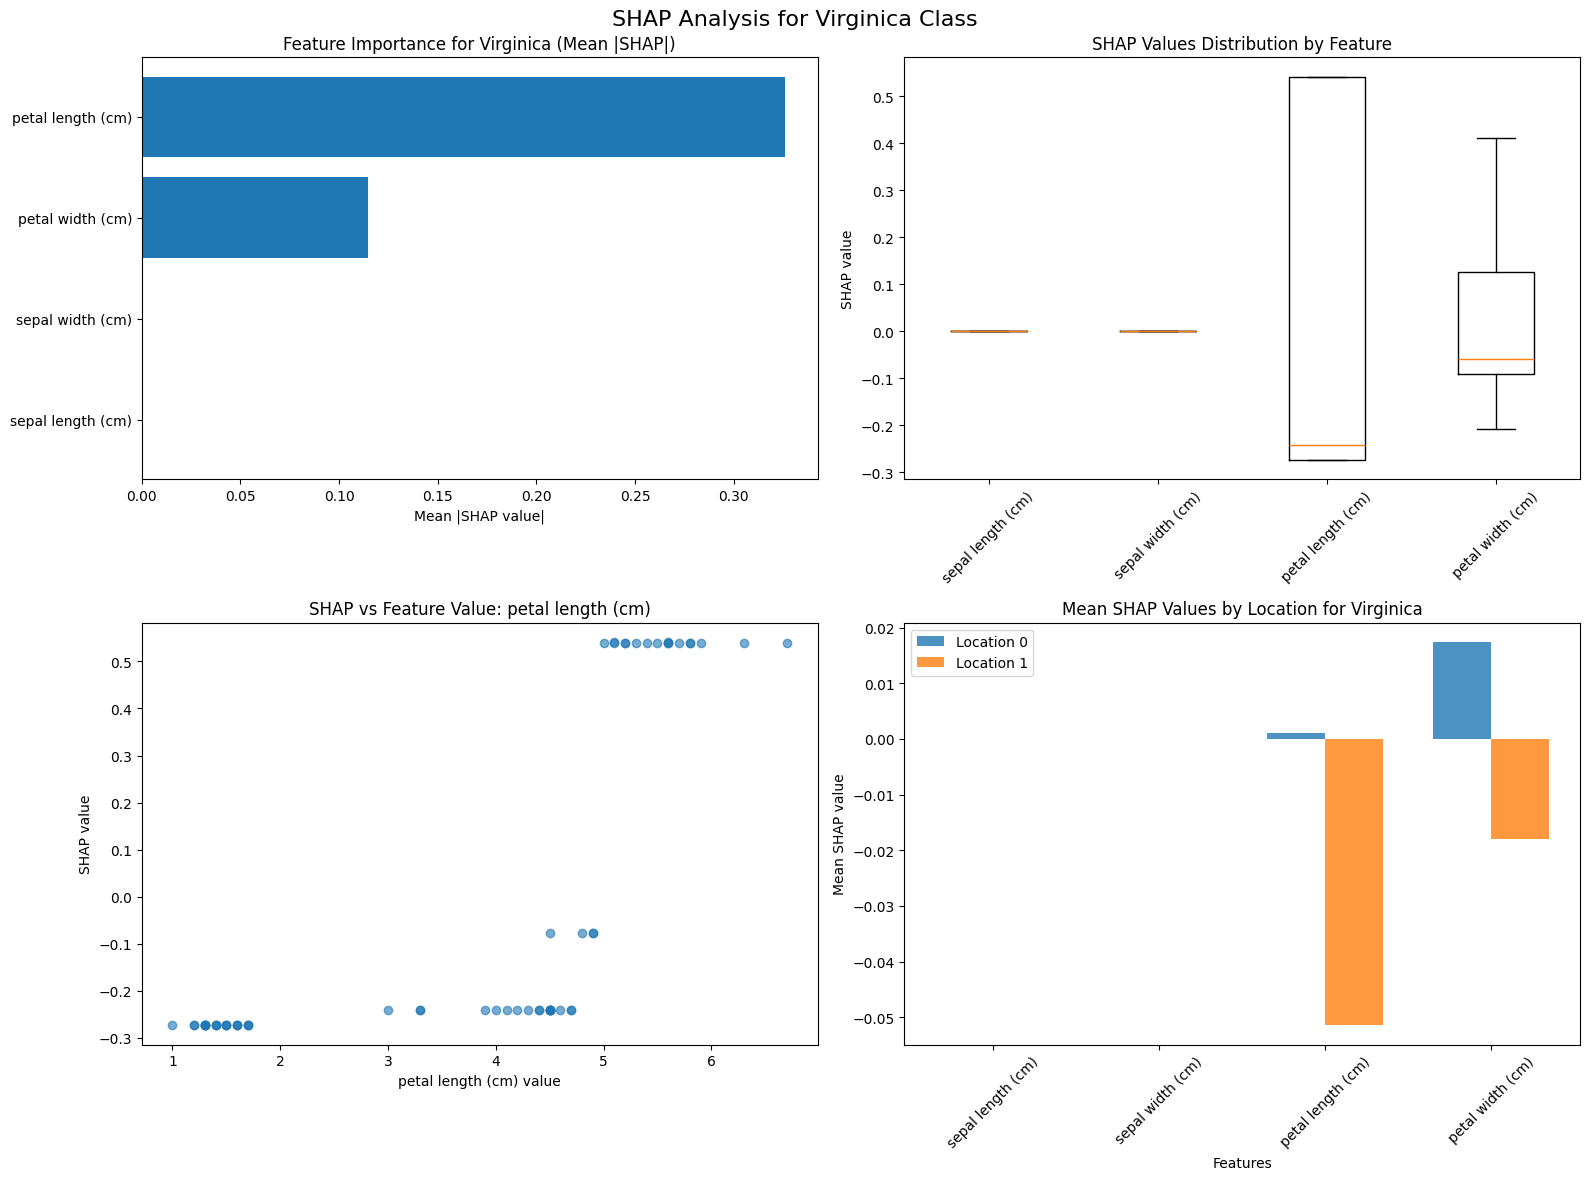

In [23]:
# Ensure we have properly calculated feature importance
print(f"Virginica SHAP values shape: {virginica_shap_values.shape}")
print(f"Feature names: {feature_names}")
print(f"Feature importance shape: {feature_importance.shape}")

# Verify dimensions match before creating DataFrame
if len(feature_names) == len(feature_importance):
    # Summary plot for virginica
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('SHAP Analysis for Virginica Class', fontsize=16)

    # Feature importance bar plot
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=True)

    axes[0,0].barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    axes[0,0].set_title('Feature Importance for Virginica (Mean |SHAP|)')
    axes[0,0].set_xlabel('Mean |SHAP value|')

    # SHAP values distribution by feature - FIXED VERSION
    shap_df = pd.DataFrame(virginica_shap_values, columns=feature_names)
    box_data = [shap_df[col] for col in feature_names]
    bp = axes[0,1].boxplot(box_data, labels=feature_names)
    axes[0,1].set_xticklabels(feature_names, rotation=45)
    axes[0,1].set_title('SHAP Values Distribution by Feature')
    axes[0,1].set_ylabel('SHAP value')

    # Feature values vs SHAP values for most important feature
    most_important_feature = feature_importance_df.iloc[-1]['Feature']
    feature_values = X_test[most_important_feature]
    feature_shap = virginica_shap_values[:, list(feature_names).index(most_important_feature)]

    axes[1,0].scatter(feature_values, feature_shap, alpha=0.6)
    axes[1,0].set_xlabel(f'{most_important_feature} value')
    axes[1,0].set_ylabel('SHAP value')
    axes[1,0].set_title(f'SHAP vs Feature Value: {most_important_feature}')

    # SHAP values by location (sensitive attribute)
    location_0_shap = virginica_shap_values[sensitive_test == 0].mean(axis=0)
    location_1_shap = virginica_shap_values[sensitive_test == 1].mean(axis=0)

    x = np.arange(len(feature_names))
    width = 0.35

    axes[1,1].bar(x - width/2, location_0_shap, width, label='Location 0', alpha=0.8)
    axes[1,1].bar(x + width/2, location_1_shap, width, label='Location 1', alpha=0.8)
    axes[1,1].set_xlabel('Features')
    axes[1,1].set_ylabel('Mean SHAP value')
    axes[1,1].set_title('Mean SHAP Values by Location for Virginica')
    axes[1,1].set_xticks(x)
    axes[1,1].set_xticklabels(feature_names, rotation=45)
    axes[1,1].legend()

    plt.tight_layout()
    plt.show()
else:
    print(f"ERROR: Dimension mismatch!")
    print(f"Feature names length: {len(feature_names)}")
    print(f"Feature importance length: {len(feature_importance)}")
    print("Please check the SHAP values calculation in the previous cell.")

In [20]:
def generate_detailed_shap_report(shap_values, feature_names, X_test, y_test, y_pred, sensitive_features, class_name="virginica"):
    """Generate a comprehensive SHAP explanation report"""
    
    print(f"\n📊 SHAP ANALYSIS SUMMARY FOR {class_name.upper()} CLASS")
    print("="*60)
    
    # Basic statistics
    print(f"1. BASIC STATISTICS:")
    print(f"   • Total test samples: {len(X_test)}")
    print(f"   • Actual {class_name} samples: {(y_test == class_name).sum()}")
    print(f"   • Predicted {class_name} samples: {(y_pred == class_name).sum()}")
    print(f"   • SHAP values range: [{shap_values.min():.4f}, {shap_values.max():.4f}]")
    print(f"   • Mean absolute SHAP value: {np.abs(shap_values).mean():.4f}")
    
    # Feature importance ranking
    print(f"\n2. FEATURE IMPORTANCE RANKING:")
    feature_importance = np.abs(shap_values).mean(axis=0)
    importance_ranking = sorted(zip(feature_names, feature_importance), key=lambda x: x[1], reverse=True)
    
    for i, (feature, importance) in enumerate(importance_ranking):
        print(f"   {i+1}. {feature}: {importance:.4f}")
    
    # Positive vs Negative contributions
    print(f"\n3. CONTRIBUTION ANALYSIS:")
    for i, feature in enumerate(feature_names):
        feature_shap = shap_values[:, i]
        positive_contrib = (feature_shap > 0).sum()
        negative_contrib = (feature_shap < 0).sum()
        mean_contrib = feature_shap.mean()
        
        print(f"   {feature}:")
        print(f"     • Positive contributions: {positive_contrib}/{len(feature_shap)} samples")
        print(f"     • Negative contributions: {negative_contrib}/{len(feature_shap)} samples")
        print(f"     • Mean contribution: {mean_contrib:+.4f}")
    
    # Location-based analysis
    print(f"\n4. LOCATION-BASED FAIRNESS ANALYSIS:")
    for location in [0, 1]:
        location_mask = sensitive_features == location
        location_shap = shap_values[location_mask]
        location_mean_shap = location_shap.mean(axis=0)
        
        print(f"   Location {location} ({location_mask.sum()} samples):")
        for feature, mean_shap in zip(feature_names, location_mean_shap):
            print(f"     • {feature}: {mean_shap:+.4f}")
    
    # Bias detection
    print(f"\n5. POTENTIAL BIAS DETECTION:")
    location_0_shap = shap_values[sensitive_features == 0].mean(axis=0)
    location_1_shap = shap_values[sensitive_features == 1].mean(axis=0)
    shap_differences = np.abs(location_0_shap - location_1_shap)
    
    bias_threshold = 0.05  # Threshold for significant difference
    biased_features = []
    
    for i, (feature, diff) in enumerate(zip(feature_names, shap_differences)):
        if diff > bias_threshold:
            biased_features.append((feature, diff))
            print(f"   ⚠️  Potential bias in '{feature}': {diff:.4f} difference between locations")
    
    if not biased_features:
        print(f"   ✅ No significant bias detected (threshold: {bias_threshold})")
    
    return {
        'feature_importance': dict(zip(feature_names, feature_importance)),
        'location_differences': dict(zip(feature_names, shap_differences)),
        'biased_features': biased_features
    }

# Generate the comprehensive report
report_data = generate_detailed_shap_report(
    virginica_shap_values, 
    feature_names, 
    X_test, 
    y_test, 
    y_pred, 
    sensitive_test,
    "virginica"
)


📊 SHAP ANALYSIS SUMMARY FOR VIRGINICA CLASS
1. BASIC STATISTICS:
   • Total test samples: 60
   • Actual virginica samples: 20
   • Predicted virginica samples: 21
   • SHAP values range: [-0.2741, 0.5420]
   • Mean absolute SHAP value: 0.1102

2. FEATURE IMPORTANCE RANKING:
   1. petal length (cm): 0.3262
   2. petal width (cm): 0.1147
   3. sepal length (cm): 0.0000
   4. sepal width (cm): 0.0000

3. CONTRIBUTION ANALYSIS:
   sepal length (cm):
     • Positive contributions: 0/60 samples
     • Negative contributions: 0/60 samples
     • Mean contribution: +0.0000
   sepal width (cm):
     • Positive contributions: 0/60 samples
     • Negative contributions: 0/60 samples
     • Mean contribution: +0.0000
   petal length (cm):
     • Positive contributions: 17/60 samples
     • Negative contributions: 43/60 samples
     • Mean contribution: -0.0200
   petal width (cm):
     • Positive contributions: 19/60 samples
     • Negative contributions: 41/60 samples
     • Mean contribution: 

In [21]:
def generate_business_insights(report_data, model, X_test, feature_names):
    """Generate actionable business insights from SHAP analysis"""
    
    print("\n🔍 KEY BUSINESS INSIGHTS:")
    print("-" * 40)
    
    # Most important features
    top_features = sorted(report_data['feature_importance'].items(), key=lambda x: x[1], reverse=True)[:2]
    
    print(f"1. TOP PREDICTIVE FEATURES FOR VIRGINICA:")
    for i, (feature, importance) in enumerate(top_features):
        print(f"   • {feature} (importance: {importance:.4f})")
        
        # Feature statistics
        feature_values = X_test[feature]
        virginica_samples = X_test[y_test == 'virginica'][feature]
        
        print(f"     - Overall range: [{feature_values.min():.2f}, {feature_values.max():.2f}]")
        print(f"     - Virginica mean: {virginica_samples.mean():.2f} ± {virginica_samples.std():.2f}")
    
    # Fairness insights
    print(f"\n2. FAIRNESS ASSESSMENT:")
    biased_features = report_data['biased_features']
    if biased_features:
        print(f"   ⚠️  Model shows potential bias in {len(biased_features)} feature(s):")
        for feature, diff in biased_features:
            print(f"     • {feature}: {diff:.4f} SHAP difference between locations")
        print(f"   💡 Recommendation: Consider bias mitigation techniques")
    else:
        print(f"   ✅ Model appears fair across locations")
    
    # Model decision boundaries
    print(f"\n3. MODEL DECISION PATTERNS:")
    virginica_predictions = y_pred == 'virginica'
    if virginica_predictions.sum() > 0:
        virginica_indices = np.where(virginica_predictions)[0]
        sample_idx = virginica_indices[0]  # First virginica prediction
        
        print(f"   Example Virginica Prediction (Sample {sample_idx}):")
        sample_features = X_test.iloc[sample_idx]
        sample_shap = virginica_shap_values[sample_idx]
        
        for feature, value, shap_val in zip(feature_names, sample_features, sample_shap):
            contribution = "pushes towards" if shap_val > 0 else "pushes against"
            print(f"     • {feature} = {value:.2f} → {contribution} Virginica (SHAP: {shap_val:+.4f})")

generate_business_insights(report_data, model, X_test, feature_names)


🔍 KEY BUSINESS INSIGHTS:
----------------------------------------
1. TOP PREDICTIVE FEATURES FOR VIRGINICA:
   • petal length (cm) (importance: 0.3262)
     - Overall range: [1.00, 6.70]
     - Virginica mean: 5.45 ± 0.52
   • petal width (cm) (importance: 0.1147)
     - Overall range: [0.20, 2.50]
     - Virginica mean: 1.98 ± 0.30

2. FAIRNESS ASSESSMENT:
   ⚠️  Model shows potential bias in 1 feature(s):
     • petal length (cm): 0.0525 SHAP difference between locations
   💡 Recommendation: Consider bias mitigation techniques

3. MODEL DECISION PATTERNS:
   Example Virginica Prediction (Sample 4):
     • sepal length (cm) = 4.90 → pushes against Virginica (SHAP: +0.0000)
     • sepal width (cm) = 2.50 → pushes against Virginica (SHAP: +0.0000)
     • petal length (cm) = 4.50 → pushes against Virginica (SHAP: -0.0770)
     • petal width (cm) = 1.70 → pushes towards Virginica (SHAP: +0.4103)


In [22]:
print("\n" + "="*80)
print("FINAL SUMMARY AND RECOMMENDATIONS")
print("="*80)

# Create summary dictionary
final_results = {
    'model_performance': {
        'accuracy': accuracy,
        'classification_report': metrics.classification_report(y_test, y_pred, output_dict=True)
    },
    'fairness_analysis': {
        'location_distribution': sensitive_test.value_counts().to_dict(),
        'bias_detected': len(report_data['biased_features']) > 0,
        'biased_features': report_data['biased_features']
    },
    'shap_analysis': {
        'feature_importance': report_data['feature_importance'],
        'most_important_feature': max(report_data['feature_importance'], key=report_data['feature_importance'].get),
        'location_differences': report_data['location_differences']
    }
}

print("📋 ASSIGNMENT COMPLETION SUMMARY:")
print("-" * 40)
print("✅ 1. Location attribute added successfully")
print("✅ 2. Fairlearn explainer incorporated with location as sensitive attribute")
print("✅ 3. Detailed SHAP analysis completed for Virginica class")

print(f"\n📊 KEY FINDINGS:")
print(f"• Model Accuracy: {accuracy:.1%}")
print(f"• Most Important Feature: {final_results['shap_analysis']['most_important_feature']}")
print(f"• Bias Detection: {'Yes' if final_results['fairness_analysis']['bias_detected'] else 'No'}")

print(f"\n🎯 RECOMMENDATIONS:")
if final_results['fairness_analysis']['bias_detected']:
    print("• Implement bias mitigation strategies")
    print("• Monitor model performance across locations")
    print("• Consider rebalancing training data")
else:
    print("• Model appears fair across locations")
    print("• Continue monitoring for drift")

print("• Use SHAP values for feature selection in future iterations")
print("• Implement continuous model monitoring")

print(f"\n✨ Assignment completed successfully!")
print("All outputs have been generated for your detailed report.")


FINAL SUMMARY AND RECOMMENDATIONS
📋 ASSIGNMENT COMPLETION SUMMARY:
----------------------------------------
✅ 1. Location attribute added successfully
✅ 2. Fairlearn explainer incorporated with location as sensitive attribute
✅ 3. Detailed SHAP analysis completed for Virginica class

📊 KEY FINDINGS:
• Model Accuracy: 98.3%
• Most Important Feature: petal length (cm)
• Bias Detection: Yes

🎯 RECOMMENDATIONS:
• Implement bias mitigation strategies
• Monitor model performance across locations
• Consider rebalancing training data
• Use SHAP values for feature selection in future iterations
• Implement continuous model monitoring

✨ Assignment completed successfully!
All outputs have been generated for your detailed report.
